#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pengantar tentang Data Renggang dan Embeddings

**Tujuan Pembelajaran:**
* Mengonversi data string ulasan film ke dalam vektor fitur renggang
* Menerapkan model linear analisis sentimen menggunakan vektor fitur renggang
* Menerapkan model DNN analisis sentimen menggunakan embedding yang memproyeksikan data ke dalam dua dimensi
* Memvisualisasikan embedding untuk melihat hal yang telah dipelajari oleh model tentang hubungan antarkata

Dalam latihan ini, kita akan mempelajari data renggang dan bekerja dengan embeddings menggunakan data teks dari ulasan film (dari [kumpulan data IMDB ACL 2011](http://ai.stanford.edu/~amaas/data/sentiment/)). Data ini telah diproses ke dalam format `tf.Example`.  

## Penyiapan

Mari kita impor dependensinya dan download data pelatihan dan pengujian. [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) mencakup download file dan fitur penyimpanan ke cache yang dapat kita gunakan untuk mengambil kumpulan data.

In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

TensorFlow 1.x selected.
40689664/40688441 [==============================] - 2s 0us/step


## Membuat Model Analisis Sentimen

Mari kita latih model analisis sentimen pada data ini yang memprediksi apakah ulasan umumnya *positif* (diberi label 1) atau *negatif* (diberi label 0).

Untuk melakukannya, kita akan mengubah nilai string `terms` ke dalam vektor fitur menggunakan *kosakata*, yaitu daftar yang berisi setiap istilah yang ingin kita lihat dalam data. Untuk tujuan latihan ini, kita telah membuat sejumlah kecil kosakata yang berfokus pada set istilah yang terbatas. Sebagian besar istilah tersebut sangat menunjukkan hal yang *positif* atau *negatif*, namun beberapa istilah ditambahkan karena menarik untuk dianalisis.

Setiap istilah dalam kosakata dipetakan ke dalam koordinat pada vektor fitur. Untuk mengonversi nilai string `terms` contoh ke dalam format vektor ini, kita melakukan encoding dengan setiap koordinat mendapatkan nilai 0 jika istilah kosakata tidak muncul dalam string contoh, dan nilai 1 jika muncul. Istilah dalam contoh yang tidak muncul dalam kosakata tidak akan digunakan.

**CATATAN:** *Kita tentu dapat menggunakan kosakata yang lebih banyak, dan ada fitur khusus untuk membuatnya. Selain itu, bukan hanya memasukkan istilah yang tidak ada dalam kosakata, kita dapat memperkenalkan sejumlah kecil bucket OOV (out-of-vocabulary) yang mana Anda dapat meng-hash istilah yang tidak ada dalam kosakata. Kita juga dapat menggunakan pendekatan __hashing fitur__ yang melakukan hashing pada setiap istilah, bukannya membuat kosakata eksplisit. Cara ini bisa dipraktikkan, namun tidak menghasilkan penafsiran, yang berguna untuk latihan ini. Lihat modul tf.feature_column untuk mengetahui fitur yang dapat mengatasi masalah ini.*

## Membuat Pipeline Masukan

Pertama, konfigurasikan pipeline masukan untuk mengimpor data ke dalam model TensorFlow. Kita dapat menggunakan fungsi berikut untuk mengurai data pelatihan dan pengujian (yang tersedia dalam format [TFRecord](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data)) dan menampilkan kamus yang berisi fitur dan label yang sesuai.

In [3]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

Untuk memastikan bahwa fungsi bekerja sesuai yang kita harapkan, buat `TFRecordDataset` untuk data pelatihan, lalu petakan data ke fitur dan label menggunakan fungsi di atas.

In [4]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<DatasetV1Adapter shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

Jalankan sel berikut untuk mengambil contoh pertama dari kumpulan data pelatihan.

In [5]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

Sekarang, buat fungsi masukan formal yang dapat kita teruskan ke metode `train()` dari objek Estimator TensorFlow.

In [6]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

## Tugas 1: Gunakan Model Linear dengan Masukan Renggang dan Kosakata Eksplisit

Untuk model pertama, kita akan membuat model [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) menggunakan 50 istilah informatif; kita mulai dengan yang sederhana.

Kode berikut membuat kolom fitur untuk istilah kita. Fungsi [`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) membuat kolom fitur dengan pemetaan string ke vektor fitur.

In [7]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

Berikutnya, kita akan membuat `LinearClassifier`, latih model tersebut di set pelatihan, lalu lakukan evaluasi di set evaluasi. Setelah membaca kodenya, jalankan dan lihat bagaimana hasil yang Anda dapatkan.

In [8]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78644
accuracy_baseline 0.5
auc 0.87162983
auc_precision_recall 0.86284673
average_loss 0.45080796
label/mean 0.5
loss 11.270199
precision 0.76939285
prediction/mean 0.4977494
recall 0.81808
global_step 1000
---
Test set metrics:
accuracy 0.7848
accuracy_baseline 0.5
auc 0.8695572
auc_precision_recall 0.85998636
average_loss 0.452565
label/mean 0.5
loss 11.314125
precision 0.7686387
prediction/mean 0.4962568
recall 0.81488
global_step 1000
---


## Tugas 2: Gunakan Model Jaringan Neural Dalam (DNN)

Model di atas adalah model linear. Model tersebut dapat berfungsi cukup baik. Namun apakah kita dapat melakukan lebih baik dengan model DNN?

Mari kita ganti model `LinearClassifier` dengan [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier). Jalankan sel berikut, dan lihat bagaimana hasil yang Anda dapatkan.

In [9]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.72
accuracy_baseline 0.6
auc 0.88666666
auc_precision_recall 0.8863978
average_loss 0.48358402
label/mean 0.4
loss 12.089601
precision 0.6
prediction/mean 0.5363146
recall 0.9
global_step 1000
---
Test set metrics:
accuracy 0.8
accuracy_baseline 0.52
auc 0.8974359
auc_precision_recall 0.9204722
average_loss 0.4261836
label/mean 0.52
loss 10.654591
precision 0.75
prediction/mean 0.5595286
recall 0.9230769
global_step 1000
---


## Tugas 3: Gunakan Embedding dengan Model DNN

Dalam tugas ini, kita akan menerapkan model DNN menggunakan kolom embedding. Kolom embedding menggunakan data renggang sebagai masukan dan menampilkan vektor padat yang berdimensi lebih rendah sebagai keluaran.

**CATATAN:** *Kolom embedding_column biasanya merupakan opsi yang secara komputasional paling efisien digunakan untuk melatih model pada data renggang. Pada [bagian opsional](#scrollTo=XDMlGgRfKSVz) di bagian akhir latihan ini, kita akan berdiskusi secara lebih mendalam tentang perbedaan implementasional antara penggunaan `embedding_column` dan `indicator_column`, dan dampak dari memilih kolom yang satu daripada yang lain.*

Dalam kode berikut, lakukan hal berikut:

* Tentukan kolom fitur untuk model menggunakan `embedding_column` yang memproyeksikan data ke dalam 2 dimensi (lihat [TF docs](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) guna mengetahui detail selengkapnya tentang tanda tangan fungsi untuk `embedding_column`).
* Tentukan `DNNClassifier` dengan spesifikasi berikut:
  * Dua lapisan tersembunyi yang masing-masing berisi 20 unit
  * Pengoptimalan AdaGrad dengan kecepatan pembelajaran sebesar 0,1
  * `gradient_clip_norm` sebesar 5,0

**CATATAN:** *Dalam praktiknya, kita mungkin memproyeksikan ke dimensi yang lebih tinggi dari 2, seperti 50 atau 100. Namun untuk saat ini, 2 dimensi mudah divisualisasikan.*

### Petunjuk

In [10]:
# Here's a example code snippet you might use to define the feature columns:

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

### Isi Kode Di Bawah

In [24]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[20,20],
    optimizer=my_optimizer
)


################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78204
accuracy_baseline 0.5
auc 0.8689479
auc_precision_recall 0.85807115
average_loss 0.4601405
label/mean 0.5
loss 11.503512
precision 0.74308765
prediction/mean 0.5432415
recall 0.86216
global_step 1000
---
Test set metrics:
accuracy 0.78268
accuracy_baseline 0.5
auc 0.86864644
auc_precision_recall 0.85678875
average_loss 0.46020347
label/mean 0.5
loss 11.505087
precision 0.74475306
prediction/mean 0.5422378
recall 0.86016
global_step 1000
---


### Solusi

Klik di bawah untuk mendapatkan solusi.

In [14]:
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

KeyboardInterrupt: ignored

## Tugas 4: Yakinkan diri Anda bahwa sebenarnya ada embedding di sana

Model di atas menggunakan `embedding_column`, dan tampaknya berfungsi, namun tidak memberikan banyak informasi tentang apa yang terjadi secara internal. Bagaimana kita dapat memeriksa bahwa model sebenarnya menggunakan embedding di dalam?

Untuk memulai, lihat tensor dalam model:

In [19]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

Oke, kita dapat melihat bahwa ada lapisan embedding di sana: `'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`. (Yang menarik di sini adalah bahwa lapisan ini dapat dilatih bersama dengan lapisan yang lain dalam model, seperti halnya lapisan tersembunyi.)

Apakah lapisan embedding merupakan bentuk yang benar? Jalankan kode berikut untuk mengetahui jawabannya.

**CATATAN:** *Perlu diingat bahwa, dalam kasus kita, embedding adalah matriks yang memungkinkan kita memproyeksikan vektor 50 dimensi menjadi 2 dimensi.*

In [20]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

Luangkan waktu untuk memeriksa secara manual berbagai lapisan dan bentuk guna memastikan bahwa semuanya terhubung seperti yang Anda harapkan.

## Tugas 5: Periksa Embedding

Kini saatnya kita lihat ruang embedding yang sebenarnya, dan lihat di mana istilah berakhir dalam ruang tersebut. Lakukan hal berikut:
1. Jalankan kode berikut untuk melihat embedding yang kita latih di **Tugas 3**. Apakah segalanya berakhir sesuai yang Anda harapkan?

2. Latih ulang model dengan menjalankan kode kembali di **Tugas 3**, lalu jalankan visualisasi embedding di bawah lagi. Apa yang tetap sama? Apa yang berubah?

3. Terakhir, latih ulang model lagi hanya menggunakan 10 langkah (yang akan menghasilkan model yang bermasalah). Jalankan visualisasi embedding di bawah lagi. Apa yang Anda lihat sekarang, dan mengapa?

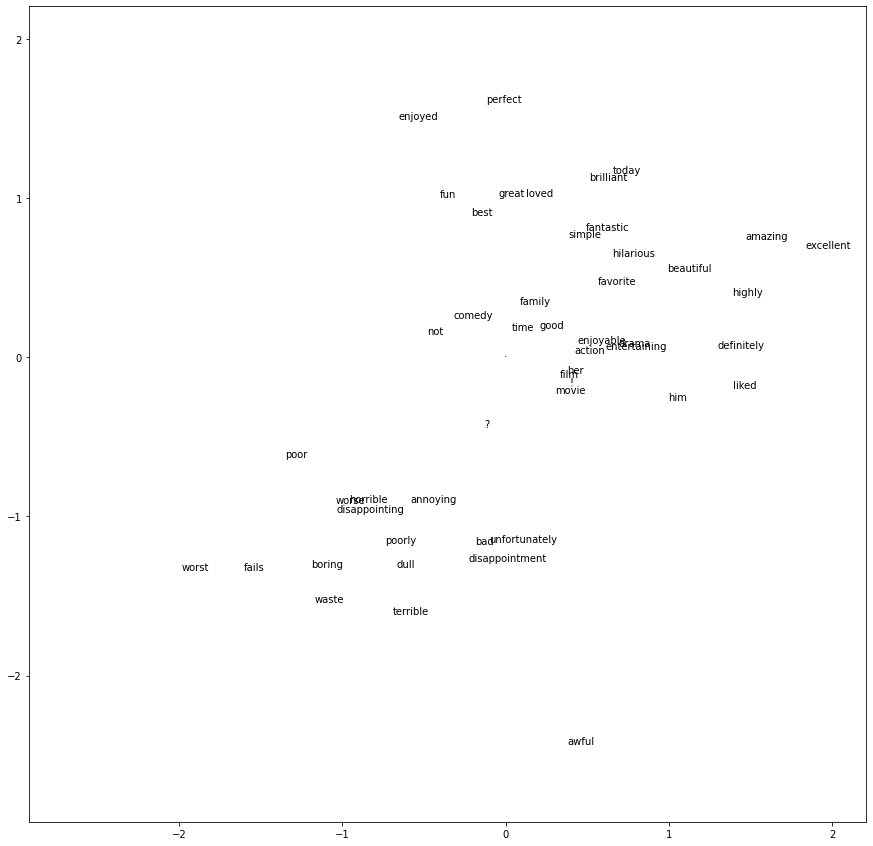

In [25]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

## Tugas 6: Coba tingkatkan performa model

Lihat apakah Anda dapat menyaring model untuk meningkatkan performa. Beberapa hal yang dapat Anda coba:

* **Mengubah hyperparameter**, atau **menggunakan pengoptimal yang berbeda** seperti Adam (Anda hanya bisa mendapatkan satu atau dua poin persentase yang akurat dengan mengikuti strategi ini).
* **Menambahkan istilah tambahan ke `informative_terms`.** Ada file kosakata lengkap yang berisi kesemua 30.716 istilah untuk kumpulan data ini yang dapat Anda gunakan di: https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt Anda dapat memilih istilah tambahan dari file kosakata ini, atau menggunakan kesemua kosakata melalui kolom fitur `categorical_column_with_vocabulary_file`.

In [26]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

253952/253538 [==============================] - 0s 0us/step


In [28]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.8308
accuracy_baseline 0.5
auc 0.9080916
auc_precision_recall 0.9050857
average_loss 0.38627318
label/mean 0.5
loss 9.656829
precision 0.8216397
prediction/mean 0.51050377
recall 0.84504
global_step 1000
---
Test set metrics:
accuracy 0.8192
accuracy_baseline 0.5
auc 0.89701563
auc_precision_recall 0.8933978
average_loss 0.40654698
label/mean 0.5
loss 10.163674
precision 0.8103609
prediction/mean 0.5103843
recall 0.83344
global_step 1000
---


## Bahasan Terakhir

Kita mungkin telah mendapatkan solusi DNN dengan embedding yang lebih baik daripada model linear asli, namun model linear juga cukup baik dan lebih cepat untuk dilatih. Model linear dilatih dengan lebih cepat karena hampir tidak memiliki sebanyak parameter untuk diperbarui atau lapisan untuk dipropagasi mundur.

Dalam beberapa penerapannya, kecepatan model linear dapat menjadi faktor penentu yang mengubah keadaan yang sudah ada secara signifikan, atau model linear dapat menjadi sangat cukup jika dilihat dari segi kualitas. Di sisi lain, kapasitas dan kompleksitas model tambahan yang diberikan oleh DNN mungkin lebih penting. Saat menentukan arsitektur model, ingatlah untuk mempelajari masalah Anda secara memadai sehingga Anda mengetahui ada di ruang mana Anda berada.

### *Diskusi Opsional:* Dampak antara `embedding_column` dan `indicator_column`

Secara konseptual, saat melatih `LinearClassifier` atau `DNNClassifier`, ada penghubung yang diperlukan untuk menggunakan kolom renggang. TF memberikan dua opsi: `embedding_column` atau `indicator_column`.

Saat melatih LinearClassifier (seperti yang diuraikan di **Tugas 1**), `embedding_column` digunakan secara implisit. Seperti yang ditunjukkan di **Tugas 2**, saat melatih `DNNClassifier`, Anda harus secara eksplisit memilih `embedding_column` atau `indicator_column`. Bagian ini membahas perbedaan antara kedua kolom tersebut, dan dampak penggunaan kolom yang satu dibandingkan dengan yang lain, dengan melihat contoh sederhana.

Anggaplah kita memiliki data renggang yang berisi nilai `"great"`, `"beautiful"`, `"excellent"`. Karena ukuran kosakata yang kita gunakan di sini adalah $V=50$, setiap unit (neuron) dalam lapisan pertama akan memiliki 50 bobot. Kita menyatakan jumlah istilah dalam masukan renggang menggunakan $s$. Jadi untuk contoh data renggang ini, $s=3$. Untuk lapisan masukan dengan nilai $V$ yang memungkinkan, lapisan tersembunyi dengan $d$ unit perlu dilakukan pengalian matriks vektor: $(1 \time V) * (V \time d)$. Lapisan ini memiliki biaya komputasional sebesar $O(V * d)$. Perlu diingat bahwa biaya ini bersifat proporsional terhadap jumlah bobot dalam lapisan tersembunyi tersebut dan terpisah dari $s$.

Jika masukan dienkode one-hot (vektor Boolean yang panjangnya $V$ dengan 1 untuk istilah yang ada dan 0 untuk yang lain) menggunakan [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column), artinya terjadi pengalian dan penambahan banyak nol.

Jika kita mendapatkan hasil yang sama persis menggunakan [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) untuk ukuran $d$, cari dan tambahkan embeddings saja yang sesuai dengan tiga fitur yang ada di masukan contoh "`great`", "`beautiful`", "`excellent`": $(1 \time d) + (1 \time d) + (1 \time d)$. Karena bobot fitur yang tidak ada dikalikan nol di pengalian matriks vektor, bobot tersebut tidak memiliki kontribusi pada hasil. Bobot fitur yang ada dikalikan 1 di pengalian matriks vektor. Jadi, penambahan bobot yang diperoleh melalui pencarian embedding akan menghasilkan hasil yang sama dengan pengalian matriks vektor.

Saat menggunakan embedding, menghitung pencarian embedding merupakan penghitungan $O(s * d)$, yang secara komputasional jauh lebih efisien daripada biaya $O(V * d)$ untuk `indicator_column` dalam data renggang yang mana $s$ jauh lebih kecil daripada $V$. (Perlu diingat, embeddings ini sedang dipelajari. Pada semua iterasi pelatihan yang diberikan, ini adalah bobot yang sedang dicari.)

Seperti yang kita lihat di **Tugas 3**, dengan menggunakan `embedding_column` dalam melatih `DNNClassifier`, model kita mempelajari representasi yang berdimensi rendah untuk fitur, yang mana produk dot menentukan metrik kemiripan yang sesuai dengan tugas yang diinginkan. Dalam contoh ini, istilah yang digunakan secara mirip dalam konteks ulasan film (mis., `"great"` dan `"excellent"`) akan saling mendekat di ruang embedding (mis., memiliki produk dot yang besar), dan istilah yang tidak mirip (mis, `"great"` dan `"bad"`) akan saling menjauh di ruang embedding (mis., memiliki produk dot kecil).